In [69]:
# number of CPUs to be used
NCPU=20

## Load and process the dataset

In [70]:
import json, gzip
import numpy as np
from sklearn.model_selection import train_test_split

aa2idx = {'A':0, 'R':1, 'N':2, 'D':3, 'C':4, 'Q':5, 'E':6, 'G':7, 'H':8, 'I':9,
          'L':10, 'K':11, 'M':12, 'F':13, 'P':14, 'S':15, 'T':16, 'W':17, 'Y':18, 'V':19}

# read .json file
with gzip.open('../data/phipsi.json.gz', 'rb') as f:
    dataset = json.loads(f.read().decode('utf-8'))

# reduse dataset to a list for simpler access
dataset = dataset['phipsi10882']

# convert data to numpy arrays skipping first and last residues
for item in dataset:
    n = len(item['sequence'])
    item['sequence'] = np.array([aa2idx[aa] for aa in item['sequence'][1:n-1]], dtype=np.int8)
    item['phi'] = np.array(item['phi'], dtype=np.float32)[1:n-1]
    item['psi'] = np.array(item['psi'], dtype=np.float32)[1:n-1]
    
    # convert (phi,psi) to their sin() and cos()
    # (4 numbers per angle pair)
    item['avec'] = np.vstack([
        np.sin(item['phi']).T,
        np.cos(item['phi']).T,
        np.sin(item['psi']).T,
        np.cos(item['psi']).T ]).T

# 90% train, 10% test
train,test = train_test_split(dataset, test_size=0.1, random_state=42)


In [71]:
%%time
from sklearn.cluster import KMeans

# split train set into 20 clusters
KMEANS = KMeans(n_clusters=20, max_iter=5, n_jobs=NCPU)
KMEANS.fit(np.vstack([item['avec'] for item in train]))

CPU times: user 1.65 s, sys: 5.09 s, total: 6.74 s
Wall time: 32.1 s


## Help functions

In [72]:
# assign each (phi,psi) to a cluster
# (KMEANS stores clustering results)
def set_clusters(train, test, KMEANS):
    for subset in (train, test):
        for item in subset:
            item['abin'] = np.array(KMEANS.predict(item['avec']), dtype=np.int8)
            

In [73]:
# split all sequences into chunks of size WINDOW
def set_window(train, test, WINDOW):
    
    for subset in (train, test):
        for item in subset:
            l = len(item['sequence'])

            abin = item['abin']
            seq = item['sequence']

            # for every window, pick the element in the middle and
            # save corresponding dihedral cluster ID in item['Y']
            item['Y'] = np.hstack([item[WINDOW//2] 
                                   for shift in range(0,WINDOW,1) 
                                   for item in np.split(abin[shift:],range(0,l,WINDOW)) 
                                   if len(item) == WINDOW])

            # use 1-hot encoding for every sequence chunk
            seq_chunks = np.vstack([item for shift in range(0,WINDOW,1) 
                                    for item in np.split(seq[shift:],range(0,l,WINDOW)) 
                                    if len(item) == WINDOW])
            item['X'] = np.array(np.eye(20)[seq_chunks], dtype=np.int8).reshape((seq_chunks.shape[0],-1))
            

In [88]:
# accuracy of the predicted angles
def rmse(test, KMEANS, SGD, WINDOW):
    
    rmse_phi = 0.0
    rmse_psi = 0.0
    
    tot = 0
    
    for item in test:
        
        l = len(item['sequence'])

        # predicted (phi,psi)
        avec = np.matmul(SGD.predict_proba(item['X']), KMEANS.cluster_centers_)
        #avec = (KMEANS.cluster_centers_)[sgd.predict(item['X'])]
        norm_phi = np.sqrt(np.square(avec[:,0])+np.square(avec[:,1]))
        norm_psi = np.sqrt(np.square(avec[:,2])+np.square(avec[:,3]))
        phi_pred = np.arctan2(avec[:,0] / norm_phi, avec[:,1] / norm_phi)
        psi_pred = np.arctan2(avec[:,2] / norm_psi, avec[:,3] / norm_psi)
    
        # reference (phi,psi)
        phi = item['phi']
        phi_ref = np.hstack([item[WINDOW//2] 
                             for shift in range(0,WINDOW,1) 
                             for item in np.split(phi[shift:],range(0,l,WINDOW)) 
                             if len(item) == WINDOW])
        psi = item['psi']
        psi_ref = np.hstack([item[WINDOW//2] 
                             for shift in range(0,WINDOW,1) 
                             for item in np.split(psi[shift:],range(0,l,WINDOW)) 
                             if len(item) == WINDOW])

        rmse_phi += np.sum(
            np.square(
                np.minimum(
                    np.abs(phi_pred - phi_ref), 
                    np.abs(phi_pred - phi_ref + 2*np.pi),
                    np.abs(phi_pred - phi_ref - 2*np.pi))))
        
        rmse_psi += np.sum(
            np.square(
                np.minimum(
                    np.abs(psi_pred - psi_ref), 
                    np.abs(psi_pred - psi_ref + 2*np.pi),
                    np.abs(psi_pred - psi_ref - 2*np.pi))))
        
        tot += psi_ref.shape[0]
    
    rmse_phi = 180. * np.sqrt(rmse_phi / tot) / np.pi
    rmse_psi = 180. * np.sqrt(rmse_psi / tot) / np.pi
    
    return rmse_phi, rmse_psi


## Randomness in clustering

K-means clustering is not guarantied to converge to the best  global solution each time you run it, but rather gives you a local suboptimal splitting. To check how this randomness in the k-means clusters affects the full angle prediction pipeline, we repeat clustering-training-testing procedure multiple times (number of clusters is fixed) and compare the results.

In [90]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

WINDOW = 15

niter = 20

KMEANS = []

for i in range(niter):
    
    # cluster
    KM = KMeans(n_clusters=20, max_iter=5, n_jobs=NCPU)
    KM.fit(np.vstack([item['avec'] for item in train]))
    
    # update item['abin']
    set_clusters(train, test, KM)
    KMEANS.append(KM)

    # unpdate item['X'] and item['Y']
    set_window(train, test, WINDOW)
    
    # TODO: with fixed WINDOW, there is no need in 
    #       updating X_train,X_test at every iteration
    X_train = np.vstack([item['X'] for item in train])
    Y_train = np.hstack([item['Y'] for item in train])
    X_test = np.vstack([item['X'] for item in test])
    Y_test = np.hstack([item['Y'] for item in test])

    sgd = SGDClassifier(max_iter=10, tol=1e-3, loss='log', n_jobs=NCPU)
    sgd.fit(X_train, Y_train)
    
    score_train = sgd.score(X_train, Y_train)
    score_test = sgd.score(X_test, Y_test)
    
    loss = log_loss(Y_test, sgd.predict_proba(X_test))

    rmse_phi, rmse_psi = rmse(test, KM, sgd, WINDOW)
    
    print(i, score_train, score_test, loss, rmse_phi, rmse_psi)

0 0.30603955258589693 0.30611681277171976 2.210410966736368 44.63115160752174 87.91542340567818
1 0.26556771814226143 0.2642942413227853 2.260902548962147 44.46571218093075 87.18822739055406


KeyboardInterrupt: 

In [93]:
from sklearn.neural_network import MLPClassifier

WINDOW=15

KM = KMeans(n_clusters=20, max_iter=5, n_jobs=NCPU)
KM.fit(np.vstack([item['avec'] for item in train]))
    
set_clusters(train, test, KM)
set_window(train, test, WINDOW)
    
X_train = np.vstack([item['X'] for item in train])
Y_train = np.hstack([item['Y'] for item in train])
X_test = np.vstack([item['X'] for item in test])
Y_test = np.hstack([item['Y'] for item in test])

mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(64,32), max_iter=10, verbose=1)
mlp.fit(X_train, Y_train)
    
score_train = mlp.score(X_train, Y_train)
score_test = mlp.score(X_test, Y_test)
    
loss = log_loss(Y_test, mlp.predict_proba(X_test))

rmse_phi, rmse_psi = rmse(test, KM, mlp, WINDOW)
    
print(score_train, score_test, loss, rmse_phi, rmse_psi)

Iteration 1, loss = 2.13845546
Iteration 2, loss = 2.08473405
Iteration 3, loss = 2.07397601
Iteration 4, loss = 2.06812087
Iteration 5, loss = 2.06447458
Iteration 6, loss = 2.06210044
Iteration 7, loss = 2.06019155
Iteration 8, loss = 2.05869190
Iteration 9, loss = 2.05739015
Iteration 10, loss = 2.05631263


/projects/omics/prog/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.35125552619758765 0.3483358278098496 2.06674070548123 42.38601470259145 82.02479381690176


In [10]:
import pickle

with open('../data/clusterst/nclust20/avg.pkl', 'wb') as output:
    pickle.dump(KMEANS[3], output, pickle.HIGHEST_PROTOCOL)

In [11]:
with open('../data/clusterst/nclust20/best.pkl', 'rb') as f:
    KM_best = pickle.load(f)

with open('../data/clusterst/nclust20/avg.pkl', 'rb') as f:
    KM_avg = pickle.load(f)

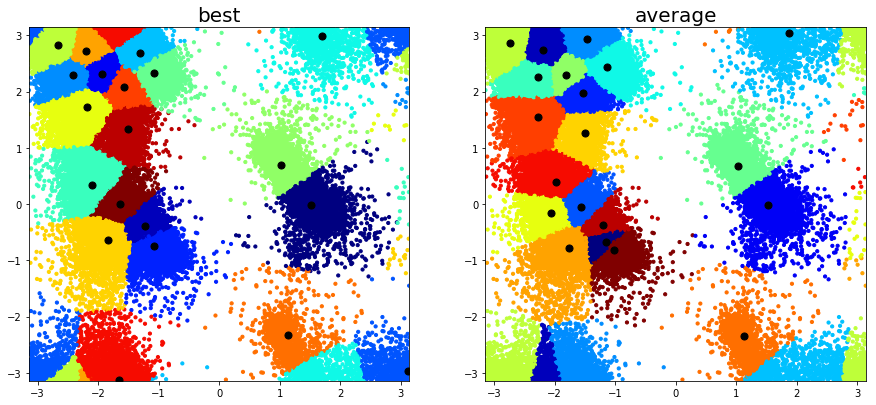

In [24]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# stack phi and psi from all test together
# (again, use 1/50 of the full set)
phi = np.hstack([item['phi'] for item in test])
psi = np.hstack([item['psi'] for item in test])

# best clusters
cent = KM_best.cluster_centers_
cphi_best = np.arctan2(cent[:,0], cent[:,1])
cpsi_best = np.arctan2(cent[:,2], cent[:,3])
lables_best = KM_best.predict(np.vstack([item['avec'] for item in test]))

# average clusters
cent = KM_avg.cluster_centers_
cphi_avg = np.arctan2(cent[:,0], cent[:,1])
cpsi_avg = np.arctan2(cent[:,2], cent[:,3])
lables_avg = KM_avg.predict(np.vstack([item['avec'] for item in test]))

# plot
matplotlib.rcParams['image.cmap'] = 'jet'

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6.5)

# set style
for col in (0,1):
    ax[col].set_xlim([-np.pi,np.pi])
    ax[col].set_ylim([-np.pi,np.pi])
    ax[col].set_xticks((-3,-2,-1,0,1,2,3))
    ax[col].set_yticks((-3,-2,-1,0,1,2,3))

ax[0].set_title("best", fontsize=20)
ax[0].scatter(phi, psi, c=lables_best, s=10)
ax[0].scatter(cphi_best, cpsi_best, c='black', s=50)

ax[1].set_title("average", fontsize=20)
ax[1].scatter(phi, psi, c=lables_avg, s=10)
ax[1].scatter(cphi_avg, cpsi_avg, c='black', s=50)

plt.show()

## Optimal window size

In [26]:
WINDOW = 15

set_clusters(train, test, KM_best)
set_window(train, test, WINDOW)
    
X_train = np.vstack([item['X'] for item in train])
Y_train = np.hstack([item['Y'] for item in train])
X_test = np.vstack([item['X'] for item in test])
Y_test = np.hstack([item['Y'] for item in test])

sgd = SGDClassifier(max_iter=10, tol=1e-3, loss='log', n_jobs=NCPU)
sgd.fit(X_train, Y_train)
    
print("best:", sgd.score(X_train, Y_train), sgd.score(X_test, Y_test), log_loss(Y_test, sgd.predict_proba(X_test)))

best: 0.3599141901898353 0.360122229349298 2.103259802692481


In [53]:
rmse(test, KM_best, sgd, 15)

IndexError: index 19 is out of bounds for axis 0 with size 15

## Regularization strength tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

#params = {'l1_ratio' : np.linspace(0.0, 1.0, 11), 'alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] }
params = {'l1_ratio' : np.linspace(0.0, 1.0, 11)}

X_train = np.vstack([item['X'] for item in train[::10]])
Y_train = np.hstack([item['Y'] for item in train[::10]])

sgd = SGDClassifier(max_iter=100, tol=1e-3, loss='log', n_jobs=4)
hsearch = GridSearchCV(sgd, params, cv=5, verbose=2, n_jobs=5)


In [ ]:
hsearch.fit(X_train, Y_train)

In [ ]:
for mean, std, params in zip(means, stds, hsearch.cv_results_['params']):
       print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))

## Number of clusters